In [30]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [31]:
# This file contains all the main external libs we'll use
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *

In [32]:
import pandas as pd
import datetime

In [33]:
#大小一般为240或299
sz=240

In [34]:
#DATA_PATH 目录下应该有train文件夹和valid文件夹 fastai 根据这两个目录的来进行train和valid
DATA_PATH = './data/'
TRAIN_DATA_PATH = DATA_PATH + 'train'
VALID_DATA_PATH = DATA_PATH + 'valid'
ALL_DATA_PATH = DATA_PATH + 'all'
TEST_IMG_PATH = DATA_PATH + 'test'
SUBMISSION_PATH = DATA_PATH + 'submission/'

In [35]:
all_plant_names = os.listdir(ALL_DATA_PATH)
train_plant_names = os.listdir(TRAIN_DATA_PATH)
valid_plant_names = os.listdir(VALID_DATA_PATH)

In [36]:
print("all_plant_count = " + str(len(all_plant_names)))
print("train_plant_count = " + str(len(train_plant_names)))
print("valid_plant_count = " + str(len(valid_plant_names)))

all_plant_count = 12
train_plant_count = 12
valid_plant_count = 12


In [37]:
def get_plants_count(path, ):
    plant_counts = []
    for pn in all_plant_names:
        plant_imgs = os.listdir(path + '/' + pn)
        plant_counts.append(len(plant_imgs))
    return plant_counts

In [38]:
# plt.figure(figsize = [15, 5])
# plt.xticks(rotation=45)
# plt.bar(plant_names, plant_counts)
# plt.show()

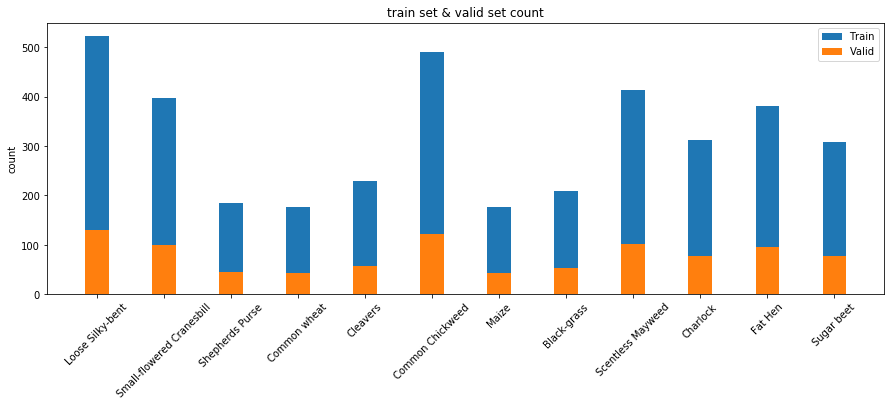

In [39]:
width = 0.35

plt.figure(figsize = [15, 5])
train_bar = plt.bar(all_plant_names, get_plants_count(TRAIN_DATA_PATH), width)
valid_bar = plt.bar(all_plant_names, get_plants_count(VALID_DATA_PATH), width)
plt.ylabel('count')
plt.title('train set & valid set count')
plt.xticks(all_plant_names, rotation=45)
plt.legend((train_bar[0], valid_bar[0]), ('Train', 'Valid'))
plt.show()

In [40]:
#选择预训练模型
#所有的图片会被裁剪成sz×sz的大小，所以如果训练集中有长方形的图，可能重要的部分会被裁剪掉
arch=resnet101
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_top_down, max_zoom=1.1)
data = ImageClassifierData.from_paths(DATA_PATH, tfms=tfms, test_name='test')
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [41]:
#https://www.youtube.com/watch?v=IPBSB1HLNLo&feature=youtu.be
#https://medium.com/@hiromi_suenaga/deep-learning-2-part-1-lesson-1-602f73869197
#什么是学习率 learning rate：
#什么是epoch
#什么是batch
#什么是batch size
#什么是 number of batch
#什么是iteration 
#Iteration是batch需要完成一个epoch的次数

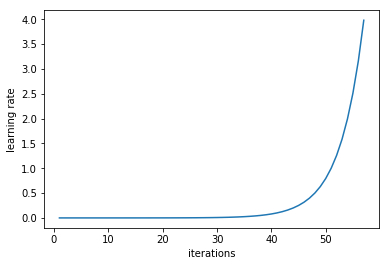

In [42]:
#选择适合的学习率
lrf=learn.lr_find()
learn.sched.plot_lr()

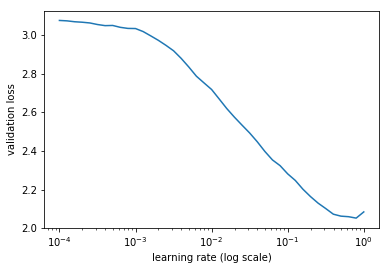

In [43]:
# 选择曲线最小值 前面的学习率(lr)
learn.sched.plot()

In [44]:
# 选择epoch 数量
# As many as you would like, but accuracy might start getting worse if you run it for too long. 
# It is something called “overfitting” and we will learn more about it later.
#learn.fit(0.1, 100)

In [45]:
lr = 1e-1
learn.fit(lr, 2, cycle_len=1) 

epoch      trn_loss   val_loss   accuracy                  
    0      1.17746    0.566273   0.803158  
    1      0.867358   0.482789   0.834737                   


[array([0.48279]), 0.8347368431091309]

In [46]:
learn.precompute = False 
learn.fit(lr, 3, cycle_len=1) 

epoch      trn_loss   val_loss   accuracy                  
    0      0.767006   0.436326   0.850526  
    1      0.71639    0.394409   0.866316                  
    2      0.638537   0.384386   0.864211                  


[array([0.38439]), 0.864210524809988]

 93%|█████████▎| 56/60 [00:20<00:01,  3.47it/s, loss=1.29] 

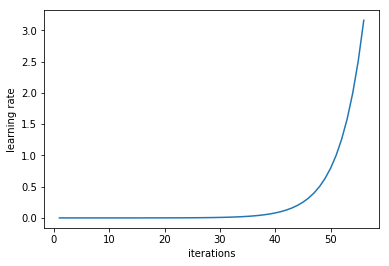

In [47]:
#选择适合的学习率
lrf=learn.lr_find()
learn.sched.plot_lr()

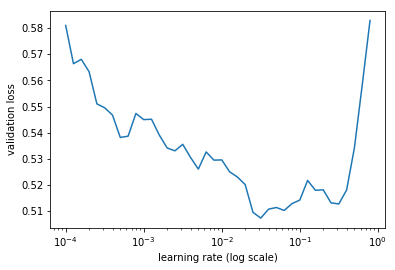

In [48]:
# 选择曲线最小值 前面的学习率(lr)
learn.sched.plot() 

In [49]:
#unfreeze
learn.unfreeze()
#三个不同的学习率 将应用于 整个网络不同的三个组，第一组是模型的前面几个层，第二个是中间层，第三个是应用于最后一层全连接层
lr=np.array([lr/100,lr/10,lr])
#cycle_len 代表是带重启的随机梯度下降算法（SGDR）
#a variant of *learning rate annealing*, 
#which gradually decreases the learning rate as training progresses. 
#This is helpful because as we get closer to the optimal weights, we want to take smaller steps.
#acosine nnealing 余弦退火模拟算法，学习率周期性变化提供比仅随机初始近似值更好的结果，每个小批次训练之后，学习速率都会改变

#cycle_save_name ：可以用于进行实验，保存最小值的训练模型
#cycle_len 每一个epoch lr会跳跃一次，
#cycle_mult 每一个epoch lr会跳跃一次，
#一个epoch 代表训练全部数据一次，cycle_len代表每次cycle输入几个epoch cycle_mult代表每个cycle是前一个cycle输入的epoch的几倍
#常用的配置还有
#learn.fit(lr, n_cycle=3, cycle_len=2)
#trn_loss 比 val_loss 小很多  说明overfit
learn.fit(lr, n_cycle=3, cycle_len=1, cycle_mult=4)

epoch      trn_loss   val_loss   accuracy                  
    0      0.579944   0.277102   0.911579  
    1      0.396398   0.432736   0.863158                  
    2      0.271458   0.19803    0.932632                  
    3      0.179155   0.112864   0.961053                  
    4      0.125034   0.116054   0.968421                  
    5      0.156158   0.220795   0.941053                  
    6      0.157698   0.252053   0.918947                  
    7      0.139316   0.169286   0.944211                  
    8      0.124952   0.140975   0.947368                  
    9      0.094728   0.081862   0.970526                   
    10     0.084677   0.123836   0.953684                   
    11     0.067412   0.096777   0.969474                   
    12     0.056441   0.107      0.967368                   
    13     0.052771   0.082278   0.972632                   
    14     0.040929   0.089056   0.975789                   
    15     0.033933   0.073484   0.981053         

[array([0.07409]), 0.9821052631578947]

In [50]:
data.sz

240

In [58]:
#TTA is test time argument 
#TTA simply makes predictions not just on the images in your validation set, 
#but also makes predictions on a number of randomly augmented versions of them too (by default, 
#it uses the original image along with 4 randomly augmented versions). 
#It then takes the average prediction from these images, and uses that. 
#To use TTA on the validation set, we can use the learner's TTA() method.
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)
accuracy_np(probs, y)

0.9810526315789474

In [59]:
#TODO 误差矩阵
preds = np.argmax(probs, axis=1)
probs = probs[:,1]

In [60]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)
plot_confusion_matrix(cm, data.classes)

NameError: name 'plot_confusion_matrix' is not defined

[[ 43   0   0   0   0   1   9   0   0   0   0   0]
 [  0  77   1   0   0   0   0   0   0   0   0   0]
 [  0   0  58   0   0   0   0   0   0   0   0   0]
 [  0   0   0 121   0   0   0   0   0   0   0   1]
 [  0   0   0   0  44   0   0   0   0   0   0   0]
 [  0   0   0   0   0  95   0   0   0   0   0   0]
 [  4   0   0   0   0   0 127   0   0   0   0   0]
 [  0   0   0   0   0   0   0  44   0   0   0   0]
 [  0   0   0   0   0   0   0   0 102   1   0   0]
 [  0   0   0   0   0   0   0   0   1  45   0   0]
 [  0   0   0   0   0   0   0   0   0   0  99   0]
 [  0   0   0   0   0   0   0   0   0   0   0  77]]


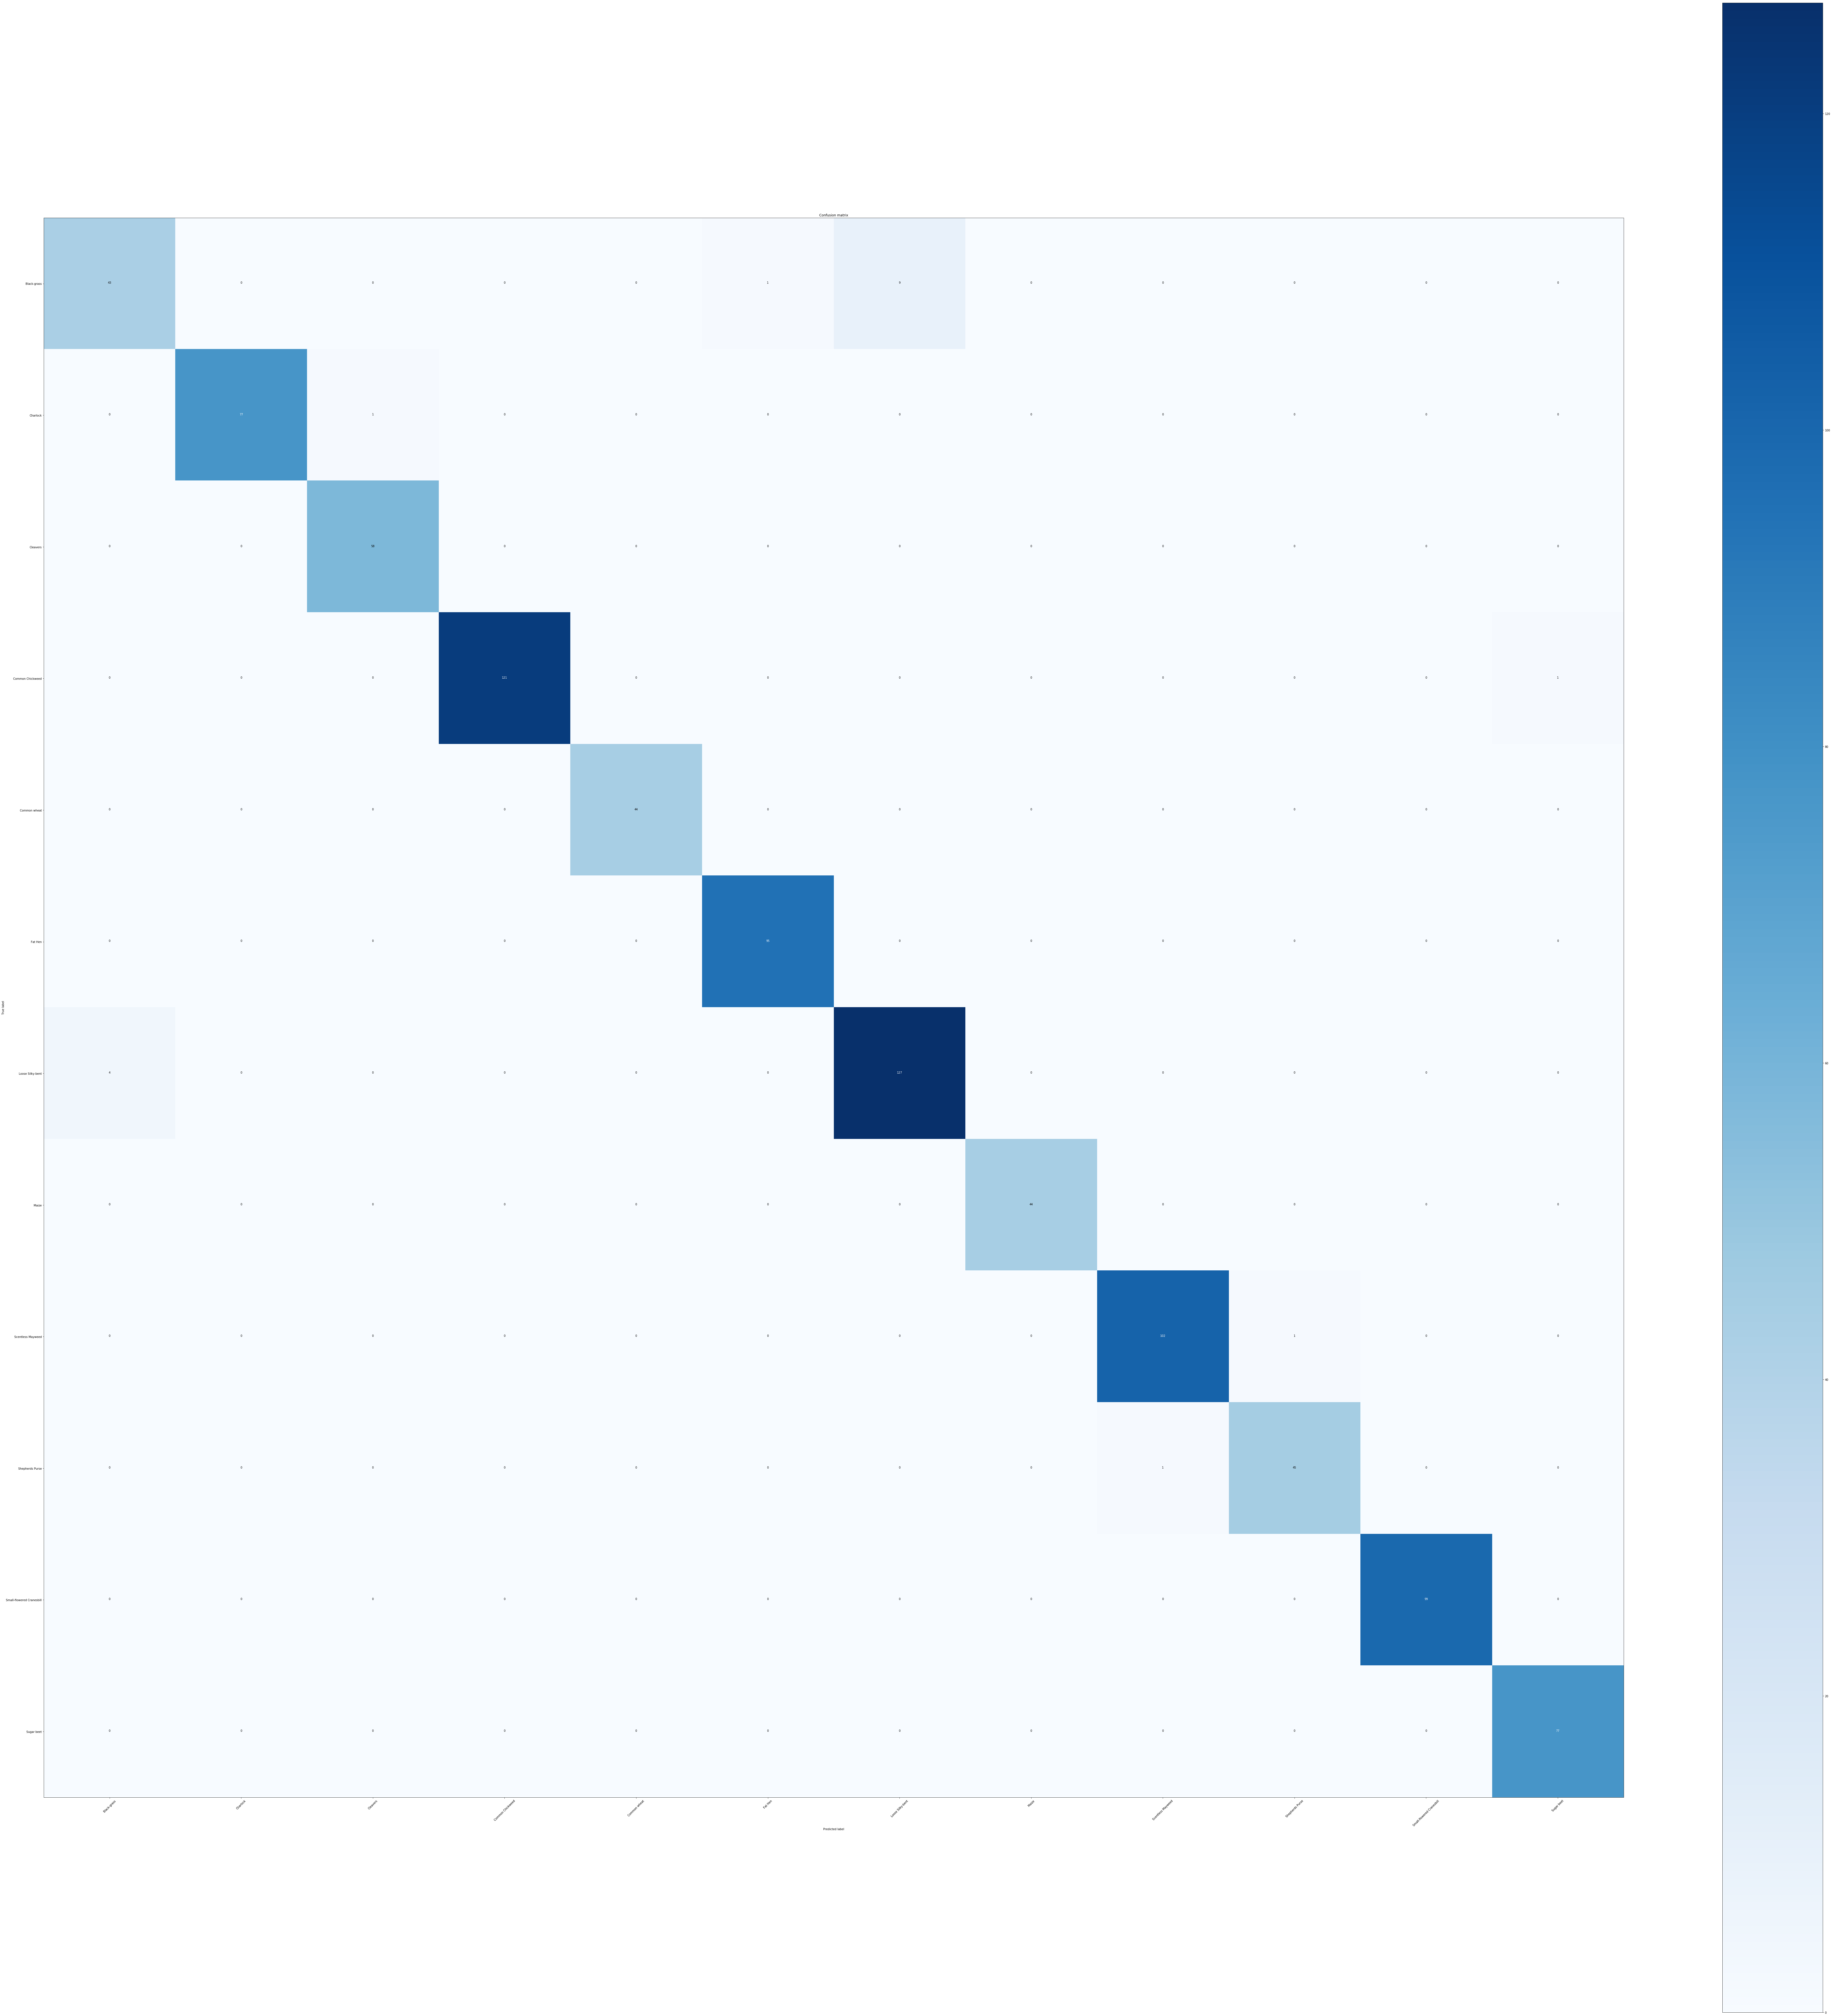

In [64]:
from fastai.plots import *
plot_confusion_matrix(cm, data.classes,figsize=[100, 100])

In [52]:
# test_predict = learn.predict(is_test = True)
test_predict, _ = learn.TTA(is_test = True)
test_predict = np.mean(np.exp(test_predict), 0)

In [53]:
test_predict_index = np.argmax(test_predict, axis=1)
test_predict_lable = [data.classes[i].replace("_", " ") for i in test_predict_index]

In [54]:
def get_file_name(path):
    return path.replace("test/", "")

In [55]:
submission = pd.DataFrame({'file':data.test_dl.dataset.fnames, 'species':test_predict_lable})
submission['file'] = submission['file'].apply(get_file_name)

In [56]:
def get_submission_path():
    return SUBMISSION_PATH + datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S') + '.csv'

In [57]:
submission.to_csv(get_submission_path(), index = False)

## to check images  which is predicted error

In [41]:
tta_probs, tta_y = learn.TTA()

In [71]:
np.set_printoptions(suppress = True,threshold = np.inf)

In [91]:
def get_valid_error_plant(real_y, predict_y, fnames):
    error_list = []
    for i in range(real_y.size):
        if real_y[i] != predict_y[i]:
            error_list.append([i, real_y[i], predict_y[i], fnames[i]])
    return error_list

In [75]:
probs = np.mean(np.exp(tta_probs),0)
val_predict_y = np.argmax(probs, axis=1)
val_real_y = tta_y


In [92]:
error_validation_plant_idx = get_valid_error_plant(val_predict_y, val_real_y, data.val_dl.dataset.fnames)

In [93]:
len(error_validation_plant_idx)

166

In [94]:
error_validation_plant_idx

[[0, 6, 0, 'valid/Black-grass/1276dffba.png'],
 [1, 6, 0, 'valid/Black-grass/87dd8ebac.png'],
 [3, 6, 0, 'valid/Black-grass/1d39b8f30.png'],
 [5, 6, 0, 'valid/Black-grass/42336b187.png'],
 [9, 4, 0, 'valid/Black-grass/fab809601.png'],
 [11, 6, 0, 'valid/Black-grass/a20b64ac6.png'],
 [13, 6, 0, 'valid/Black-grass/5a1295fb4.png'],
 [17, 6, 0, 'valid/Black-grass/a03bc7b24.png'],
 [19, 6, 0, 'valid/Black-grass/2269e0a1e.png'],
 [20, 6, 0, 'valid/Black-grass/1576ce9fd.png'],
 [21, 6, 0, 'valid/Black-grass/2ee4dad8c.png'],
 [22, 4, 0, 'valid/Black-grass/d8afd58f3.png'],
 [23, 6, 0, 'valid/Black-grass/898ecfa78.png'],
 [24, 6, 0, 'valid/Black-grass/0dad57e7f.png'],
 [25, 4, 0, 'valid/Black-grass/a0baf5f7b.png'],
 [26, 6, 0, 'valid/Black-grass/afaade548.png'],
 [29, 6, 0, 'valid/Black-grass/93f68d1a9.png'],
 [31, 6, 0, 'valid/Black-grass/163e571a6.png'],
 [32, 6, 0, 'valid/Black-grass/2f0ae1b34.png'],
 [33, 6, 0, 'valid/Black-grass/a26cb8017.png'],
 [35, 8, 0, 'valid/Black-grass/dd091a2a9.png'

In [95]:
data.classes

['Black-grass',
 'Charlock',
 'Cleavers',
 'Common Chickweed',
 'Common wheat',
 'Fat Hen',
 'Loose Silky-bent',
 'Maize',
 'Scentless Mayweed',
 'Shepherds Purse',
 'Small-flowered Cranesbill',
 'Sugar beet']

In [98]:
error_df = pd.DataFrame(error_validation_plant_idx, columns=['index', 'predict', 'real', 'file'])

In [113]:
label_0_error_df = error_df[error_df['real'] == 0]

In [114]:
label_0_error_df.groupby('predict').count()

index  real  file
predict                   
4            5     5     5
6           29    29    29
8            2     2     2

In [115]:
label_6_error_df = error_df[error_df['real'] == 6]
label_6_error_df.groupby('predict').count()

index  real  file
predict                   
0           19    19    19
4            1     1     1
5            1     1     1
8            1     1     1

In [116]:
# 统计显示0和6辨识率低

In [117]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

In [149]:
def load_img_id(ds, idx): return np.array(PIL.Image.open(DATA_PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, subtitles, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=subtitles, figsize=(4 * len(imgs),12)) if len(imgs)>0 else print('Not Found.')

In [150]:
label_0_error_df

index  predict  real                             file
0       0        6     0  valid/Black-grass/1276dffba.png
1       1        6     0  valid/Black-grass/87dd8ebac.png
2       3        6     0  valid/Black-grass/1d39b8f30.png
3       5        6     0  valid/Black-grass/42336b187.png
4       9        4     0  valid/Black-grass/fab809601.png
5      11        6     0  valid/Black-grass/a20b64ac6.png
6      13        6     0  valid/Black-grass/5a1295fb4.png
7      17        6     0  valid/Black-grass/a03bc7b24.png
8      19        6     0  valid/Black-grass/2269e0a1e.png
9      20        6     0  valid/Black-grass/1576ce9fd.png
10     21        6     0  valid/Black-grass/2ee4dad8c.png
11     22        4     0  valid/Black-grass/d8afd58f3.png
12     23        6     0  valid/Black-grass/898ecfa78.png
13     24        6     0  valid/Black-grass/0dad57e7f.png
14     25        4     0  valid/Black-grass/a0baf5f7b.png
15     26        6     0  valid/Black-grass/afaade548.png
16     29        6     0  valid/Black-grass/93f68d1a9.png
17     31        6     0  valid/Black-grass/163e571a6.png
18     32        6     0  valid/Black-grass/2f0ae1b34.png
19     33        6     0  valid/Black-grass/a26cb8017.png
20     35        8     0  valid/Black-grass/dd091a2a9.png
21     36        6     0  valid/Black-grass/a7d2b005e.png
22     38        6     0  valid/Black-grass/b9dfffe2a.png
23     39        6     0  valid/Black-grass/a08892355.png
24     40        6     0  valid/Black-grass/e67dbce63.png
25     53        6     0  valid/Black-grass/c8884407d.png
26     54        8     0  valid/Black-grass/dcbd3fa08.png
27     56        6     0  valid/Black-grass/963dbc831.png
28     61        4     0  valid/Black-grass/f20bf670a.png
29     62        6     0  valid/Black-grass/befaed3e4.png
30     64        6     0  valid/Black-grass/6172f64fd.png
31     65        4     0  valid/Black-grass/fb487c5a4.png
32     67        6     0  valid/Black-grass/b9e36fa79.png
33     68        6     0  valid/Black-grass/91a175741.png
34     69        6     0  valid/Black-grass/6182bd48c.png
35     78        6     0  valid/Black-grass/82e0d98d2.png

In [151]:
label_0_error_df['index'].as_matrix()

/home/astatus/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


array([ 0,  1,  3,  5,  9, 11, 13, 17, 19, 20, 21, 22, 23, 24, 25, 26, 29, 31, 32, 33, 35, 36, 38, 39, 40,
       53, 54, 56, 61, 62, 64, 65, 67, 68, 69, 78])

/home/astatus/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


Black-grass 0


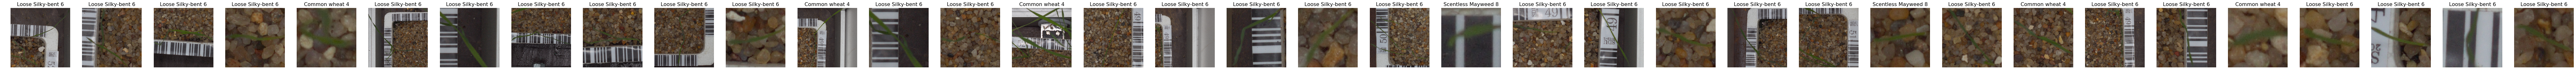

In [152]:
plot_val_with_title(label_0_error_df['index'].as_matrix(), [data.classes[i] + ' ' + str(i) for i in label_0_error_df['predict']], data.classes[0] + ' 0' )

In [153]:
data.classes[6]

'Loose Silky-bent'

In [157]:
error_df.count()

index      166
predict    166
real       166
file       166
dtype: int64

In [158]:
error_df.groupby('real').count().sort_values('index')

index  predict  file
real                      
1         5        5     5
7         5        5     5
10        8        8     8
3         9        9     9
2        10       10    10
4        11       11    11
11       11       11    11
5        14       14    14
9        14       14    14
8        21       21    21
6        22       22    22
0        36       36    36

/home/astatus/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


Scentless Mayweed 8


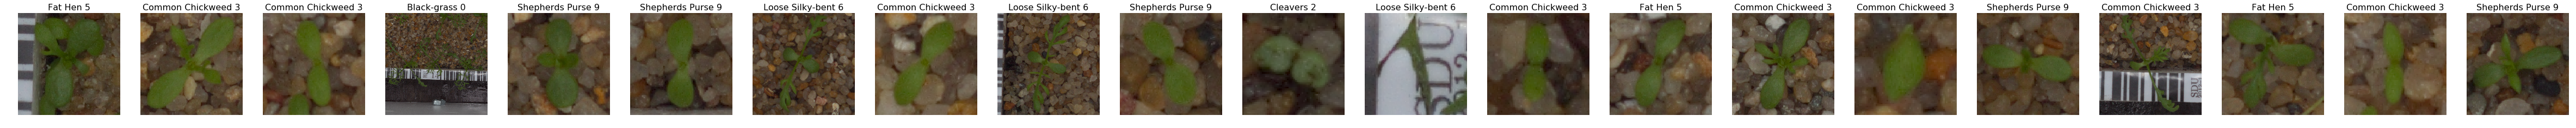

In [159]:
label_8_error_df = error_df[error_df['real'] == 8]

plot_val_with_title(label_8_error_df['index'].as_matrix(), [data.classes[i] + ' ' + str(i) for i in label_8_error_df['predict']], data.classes[8] + ' 8' )

In [160]:
label_8_error_df.groupby('predict').count()

index  real  file
predict                   
0            1     1     1
2            1     1     1
3            8     8     8
5            3     3     3
6            3     3     3
9            5     5     5

## Review: easy steps to train a world-class image classifier

1. precompute=True
1. Use `lr_find()` to find highest learning rate where loss is still clearly improving
1. Train last layer from precomputed activations for 1-2 epochs
1. Train last layer with data augmentation (i.e. precompute=False) for 2-3 epochs with cycle_len=1
1. Unfreeze all layers
1. Set earlier layers to 3x-10x lower learning rate than next higher layer
1. Use `lr_find()` again
1. Train full network with cycle_mult=2 until over-fitting